# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    965      0 --:--:-- --:--:-- --:--:--   962
100 1546k  100 1546k    0     0  1631k      0 --:--:-- --:--:-- --:--:-- 1631k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    730      0 --:--:-- --:--:-- --:--:--   729
100  385k  100  385k    0     0   443k      0 --:--:-- --:--:-- --:--:--  443k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    965      0 --:--:-- --:--:-- --:--:--   965
100  230k  100  230k    0     0   264k      0 --:--:-- --:--:-- --:--:--  894k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1MB 6.2MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419454 sha256=c9264fe7220037f8e5dce4519fac7f7634c4cfb5d6739121ce1a6e249f7695e6
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [3]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse

In [4]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [5]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [6]:
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,1,878542960
1,1,4,1,876893119
2,1,5,1,889751712
3,1,6,1,887431973
4,1,7,1,875071561


In [7]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [8]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [10]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [11]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [12]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [13]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [14]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [15]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** 
ALS es un proceso de optimización iterativo en el que, en cada iteración, intentamos acercarnos cada vez más a una representación factorizada de nuestros datos originales. Tenemos nuestra matriz R original de tamaño u x i con nuestros usuarios, elementos y algún tipo de datos de retroalimentación. Luego, queremos encontrar una manera de convertir eso en una matriz con usuarios y características ocultas de tamaño u x f y una con elementos y características ocultas de tamaño f x i. En U y V tenemos ponderaciones de cómo cada usuario / elemento se relaciona con cada característica. Lo que hacemos es calcular U y V para que su producto se aproxime lo más posible a R: R ≈ U x V.

In [16]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [17]:
show_recommendations(model_als, user=77, n=10)

movieid
258                                        Contact (1997)
256     When the Cats Away (Chacun cherche son chat) (...
292                                       Rosewood (1997)
754                                     Red Corner (1997)
409                                           Jack (1996)
273                                           Heat (1995)
257                                   Men in Black (1997)
1012                                 Private Parts (1997)
404                                      Pinocchio (1940)
357                One Flew Over the Cuckoo's Nest (1975)
Name: title, dtype: object

In [18]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.060300716837088916
ndcg: 0.34915773353751917


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

BPR el criterio de optimización está basado en pares de ítems ordenados según la preferencia del usuario, lo cual agregado a los modelos del estado del arte mejoraría la calidad del ranking.

In [19]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [20]:
show_recommendations(model_bpr, user=77, n=10)

movieid
746                                Real Genius (1985)
257                               Men in Black (1997)
327                                   Cop Land (1997)
244                     Smilla's Sense of Snow (1997)
299                                    Hoodlum (1997)
285                             Secrets & Lies (1996)
99             Snow White and the Seven Dwarfs (1937)
267                                           unknown
312    Midnight in the Garden of Good and Evil (1997)
325                                      Crash (1996)
Name: title, dtype: object

In [21]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171                Delicatessen (1991)
209          This Is Spinal Tap (1984)
68                    Crow, The (1994)
173         Princess Bride, The (1987)
78                   Free Willy (1993)
203                  Unforgiven (1992)
21       Muppet Treasure Island (1996)
167            Private Benjamin (1980)
27                     Bad Boys (1995)
172    Empire Strikes Back, The (1980)
Name: title, dtype: object

In [22]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05219162312700535
ndcg: 0.34150076569678406


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

In [24]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr1 = implicit.bpr.BayesianPersonalizedRanking(factors=100, iterations=40, use_gpu=False)
model_bpr1.fit(matrix)

In [25]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr2 = implicit.bpr.BayesianPersonalizedRanking(factors=200, iterations=40, use_gpu=False)
model_bpr2.fit(matrix)

In [26]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr3 = implicit.bpr.BayesianPersonalizedRanking(factors=300, iterations=40, use_gpu=False)
model_bpr3.fit(matrix)

In [27]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr4 = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr4.fit(matrix)

In [28]:
maprec, ndcg = evaluate_model(model_bpr1, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.04906812296151783
ndcg: 0.33537519142419603


In [29]:
maprec, ndcg = evaluate_model(model_bpr2, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.04235548418503255
ndcg: 0.3169984686064318


In [30]:
maprec, ndcg = evaluate_model(model_bpr3, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.05798450051397244
ndcg: 0.3445635528330781


In [31]:
maprec, ndcg = evaluate_model(model_bpr4, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.053812108537017796
ndcg: 0.3460949464012251


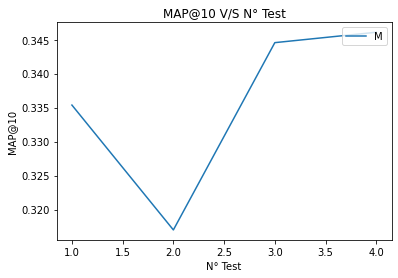

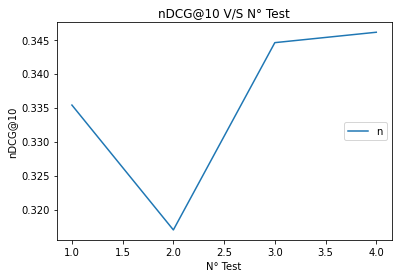

In [33]:
import numpy as np
import matplotlib.pyplot as plt


MAP10= [0.33537519142419603,0.3169984686064318,0.3445635528330781,0.3460949464012251]          
       

nDCG10 = [0.33537519142419603,0.3169984686064318,0.3445635528330781,0.3460949464012251]           


N=[1,2,3,4]



plt.plot(N, MAP10)

plt.xlabel("N° Test")
plt.ylabel("MAP@10")
plt.title("MAP@10 V/S N° Test")
plt.legend( ('MAP@10 Training'), loc = 'upper right')
plt.show()

plt.plot(N, nDCG10)
plt.xlabel("N° Test")
plt.ylabel("nDCG@10")
plt.title("nDCG@10 V/S N° Test")
plt.legend( ('nDCG@10 Training'), loc = 'center right')
plt.show()



